In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
import pandas as pd

dataset_path = "/content/drive/MyDrive/Face Mask Dataset"

image_paths = []
labels = []

for label in ['withmask', 'withoutmask']:
    folder = os.path.join(dataset_path, label)
    for file in os.listdir(folder):
        if file.lower().endswith(('.jpg', '.jpeg', '.png')):
            image_paths.append(os.path.join(folder, file))
            labels.append(label)

df = pd.DataFrame({'image_path': image_paths, 'label': labels})
print("✅ Dataset loaded!")
print(df['label'].value_counts())

✅ Dataset loaded!
label
withmask       1010
withoutmask    1000
Name: count, dtype: int64


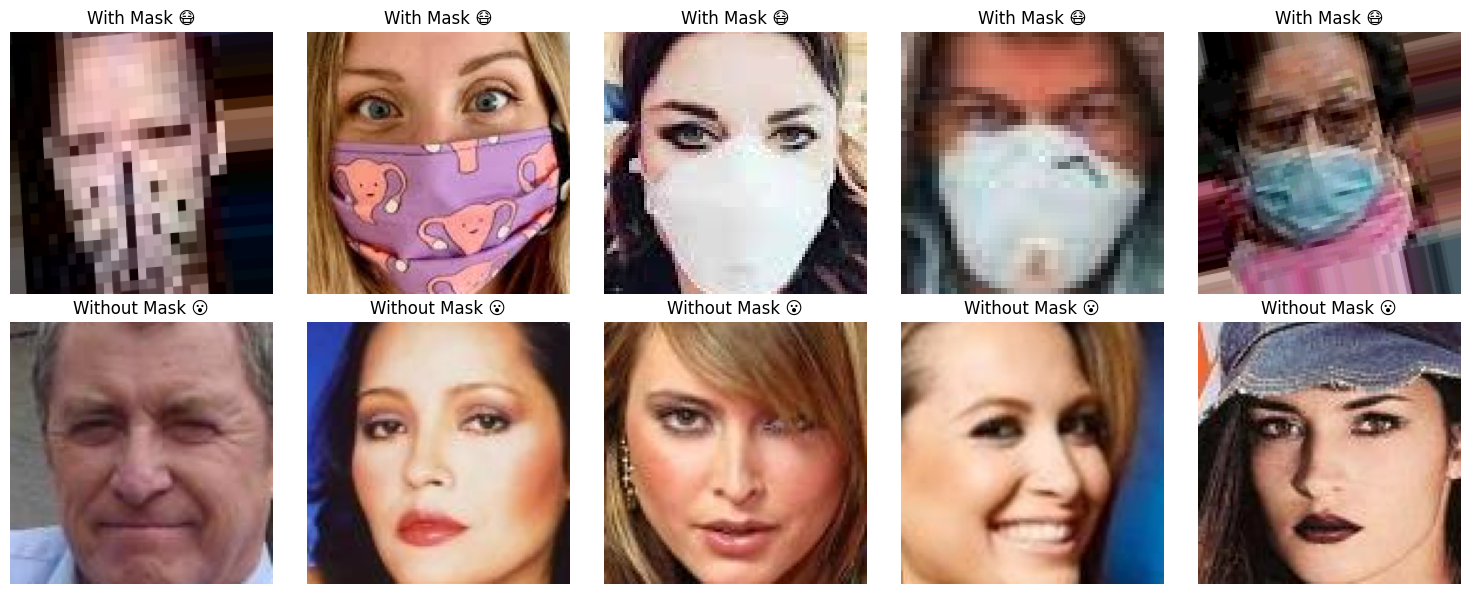

In [3]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

withmask_samples = df[df['label'] == 'withmask'].sample(5, random_state=1)
withoutmask_samples = df[df['label'] == 'withoutmask'].sample(5, random_state=1)

fig, axes = plt.subplots(2, 5, figsize=(15, 6))

for i, (_, row) in enumerate(withmask_samples.iterrows()):
    img = mpimg.imread(row['image_path'])
    axes[0, i].imshow(img)
    axes[0, i].set_title("With Mask 😷")
    axes[0, i].axis("off")

for i, (_, row) in enumerate(withoutmask_samples.iterrows()):
    img = mpimg.imread(row['image_path'])
    axes[1, i].imshow(img)
    axes[1, i].set_title("Without Mask 😮")
    axes[1, i].axis("off")

plt.tight_layout()
plt.show()

In [4]:
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

# Load and preprocess images
data = []
labels = []

for _, row in df.iterrows():
    img = load_img(row['image_path'], target_size=(224, 224))
    img = img_to_array(img)
    img = img / 255.0  # normalize
    data.append(img)
    labels.append(row['label'])

data = np.array(data, dtype="float32")
labels = np.array(labels)

# Encode labels
le = LabelEncoder()
labels = le.fit_transform(labels)
labels = to_categorical(labels)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)

print("✅ Data ready for training")
print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)

✅ Data ready for training
Train shape: (1608, 224, 224, 3)
Test shape: (402, 224, 224, 3)


In [5]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, Input
from tensorflow.keras.optimizers import Adam

# Load MobileNetV2 base (pretrained on ImageNet)
base_model = MobileNetV2(weights="imagenet", include_top=False, input_tensor=Input(shape=(224, 224, 3)))
base_model.trainable = False  # freeze base

# Add custom head
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
output = Dense(2, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)

# Compile
model.compile(optimizer=Adam(learning_rate=0.0001), loss="categorical_crossentropy", metrics=["accuracy"])

model.summary()

/tmp/ipython-input-5-2258538194.py:7: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(weights="imagenet", include_top=False, input_tensor=Input(shape=(224, 224, 3)))


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,260,546 (8.62 MB)

 Trainable params: 2,562 (10.01 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [6]:
import tensorflow as tf

# Convert to TensorFlow datasets
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(32)
val_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(32)

# Train the model (clean way, no warning)
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=10
)

Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(None, 224, 224, 3))
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(None, 224, 224, 3))
  warnings.warn(msg)


51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5903 - loss: 0.9292

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(None, 224, 224, 3))
  warnings.warn(msg)


51/51 ━━━━━━━━━━━━━━━━━━━━ 106s 2s/step - accuracy: 0.5909 - loss: 0.9269 - val_accuracy: 0.8060 - val_loss: 0.4598
Epoch 2/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 96s 2s/step - accuracy: 0.6887 - loss: 0.6158 - val_accuracy: 0.8781 - val_loss: 0.3337
Epoch 3/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 92s 2s/step - accuracy: 0.7604 - loss: 0.5008 - val_accuracy: 0.9104 - val_loss: 0.2606
Epoch 4/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 91s 2s/step - accuracy: 0.8242 - loss: 0.4350 - val_accuracy: 0.9353 - val_loss: 0.2146
Epoch 5/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 96s 2s/step - accuracy: 0.8629 - loss: 0.3348 - val_accuracy: 0.9428 - val_loss: 0.1845
Epoch 6/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 93s 2s/step - accuracy: 0.8741 - loss: 0.2901 - val_accuracy: 0.9502 - val_loss: 0.1617
Epoch 7/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 91s 2s/step - accuracy: 0.8805 - loss: 0.2742 - val_accuracy: 0.9502 - val_loss: 0.1428
Epoch 8/10
51/51 ━━━━━━━━━━━━━━━━━━━━ 116s 2s/step - accuracy: 0.9084 - loss: 0.2597 - val_accuracy: 0.9552 - val_loss: 0.1305
E

In [7]:
model.save("face_mask_model.h5")

In [8]:
from google.colab import files
files.download("face_mask_model.h5")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

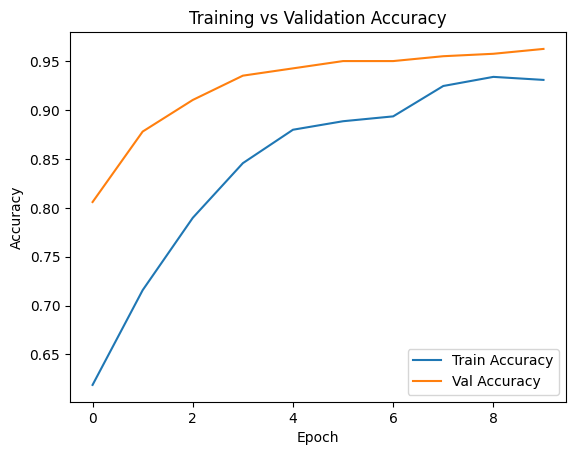

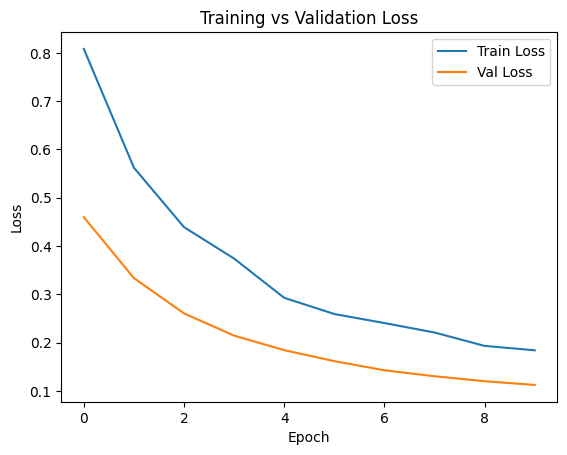

In [9]:
import matplotlib.pyplot as plt

# Accuracy plot
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Loss plot
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [10]:
from google.colab import files
uploaded = files.upload()

Saving gg.png to gg.png


In [11]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

# Replace 'group.jpg' with your uploaded filename
image_path = 'gg.png'

image = cv2.imread(image_path)
if image is None:
    print("❌ Image not loaded. Check filename.")
else:
    print("✅ Image loaded.")

# Load face detection model
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

# Convert image to grayscale
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Detect faces (returns list of (x, y, w, h))
faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=4)

print(f"✅ Detected {len(faces)} face(s)")

✅ Image loaded.
✅ Detected 2 face(s)


In [12]:
for (x, y, w, h) in faces:
    face = image[y:y+h, x:x+w]
    face = cv2.resize(face, (224, 224))
    face = face / 255.0
    face = np.expand_dims(face, axis=0)

    pred = model.predict(face)[0]
    label = 'With Mask 😷' if np.argmax(pred) == 0 else 'Without Mask 😮'
    color = (0, 255, 0) if label == 'With Mask 😷' else (0, 0, 255)

    # Draw rectangle and label
    cv2.rectangle(image, (x, y), (x + w, y + h), color, 2)
    cv2.putText(image, label, (x, y - 10),
                cv2.FONT_HERSHEY_SIMPLEX, 0.8, color, 2)

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


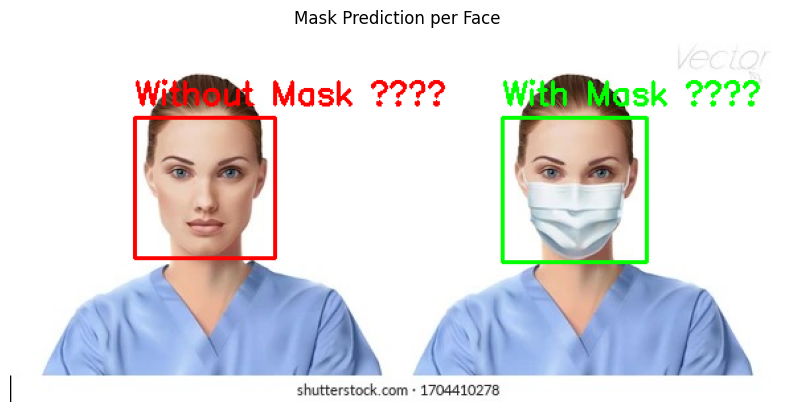

In [13]:
plt.figure(figsize=(10, 8))
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.title('Mask Prediction per Face')
plt.show()

In [14]:
from google.colab import files
uploaded = files.upload()

Saving 1.jpg to 1.jpg
Saving 2.jpg to 2.jpg
Saving 3.jpg to 3.jpg



✅ Processing: 1.jpg
✅ Detected 2 face(s)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


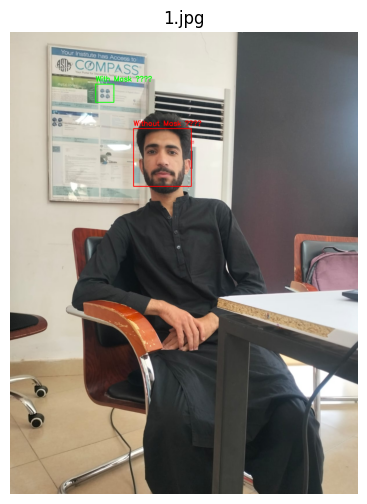


✅ Processing: 2.jpg
✅ Detected 2 face(s)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


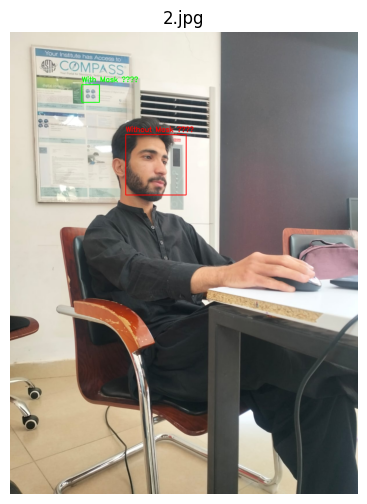


✅ Processing: 3.jpg
✅ Detected 2 face(s)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


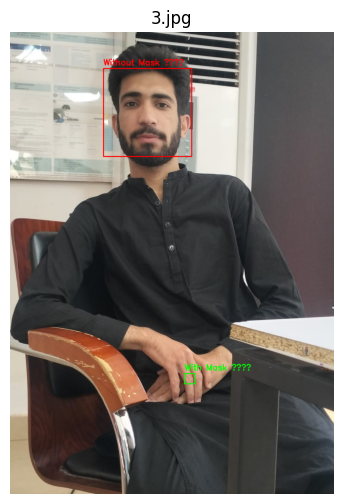

In [15]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

for filename in uploaded.keys():
    print(f"\n✅ Processing: {filename}")

    # Load image
    image = cv2.imread(filename)
    original = image.copy()

    # Face detection
    face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, 1.1, 4)

    print(f"✅ Detected {len(faces)} face(s)")

    for (x, y, w, h) in faces:
        face = image[y:y+h, x:x+w]
        face = cv2.resize(face, (224, 224))
        face = face / 255.0
        face = np.expand_dims(face, axis=0)

        prediction = model.predict(face)[0]
        label = "With Mask 😷" if np.argmax(prediction) == 0 else "Without Mask 😮"
        color = (0, 255, 0) if label == "With Mask 😷" else (0, 0, 255)

        # Draw box and label
        cv2.rectangle(image, (x, y), (x+w, y+h), color, 2)
        cv2.putText(image, label, (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.8, color, 2)

    # Show the result
    plt.figure(figsize=(6, 6))
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title(filename)
    plt.axis('off')
    plt.show()

In [25]:
from google.colab import files
uploaded = files.upload()

Saving face_mask_model.h5 to face_mask_model (1).h5


In [26]:
!pip install tensorflow opencv-python

In [27]:
import cv2
import numpy as np
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import img_to_array
import matplotlib.pyplot as plt

In [28]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode
from PIL import Image
import io

def take_photo(filename='photo.jpg', quality=0.8):
    js = Javascript('''
        async function takePhoto(quality) {
            const div = document.createElement('div');
            const capture = document.createElement('button');
            capture.textContent = '📸 Capture';
            div.appendChild(capture);

            const video = document.createElement('video');
            video.style.display = 'block';
            div.appendChild(video);
            document.body.appendChild(div);

            const stream = await navigator.mediaDevices.getUserMedia({video: true});
            video.srcObject = stream;
            await video.play();

            google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

            await new Promise((resolve) => capture.onclick = resolve);

            const canvas = document.createElement('canvas');
            canvas.width = video.videoWidth;
            canvas.height = video.videoHeight;
            canvas.getContext('2d').drawImage(video, 0, 0);
            stream.getTracks().forEach(track => track.stop());
            div.remove();

            return canvas.toDataURL('image/jpeg', quality);
        }
        takePhoto({quality: %s});
        ''' % quality)
    display(js)
    data = eval_js("takePhoto()")
    binary = b64decode(data.split(',')[1])
    with open(filename, 'wb') as f:
        f.write(binary)
    return filename

In [31]:
  image_path = take_photo()

<IPython.core.display.Javascript object>

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


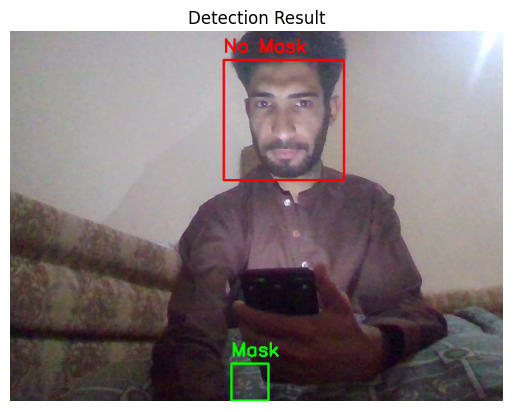

In [32]:
 # Load model
model = load_model("face_mask_model.h5")  # or .keras

# Load Haar Cascade
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

# Read image
frame = cv2.imread(image_path)
gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
faces = face_cascade.detectMultiScale(gray, 1.1, 4)

labels = ["Mask", "No Mask"]

for (x, y, w, h) in faces:
    face = frame[y:y+h, x:x+w]
    face = cv2.resize(face, (224, 224))
    face = img_to_array(face) / 255.0
    face = np.expand_dims(face, axis=0)
    prediction = model.predict(face)[0]
    label = labels[np.argmax(prediction)]
    color = (0, 255, 0) if label == "Mask" else (0, 0, 255)

    cv2.rectangle(frame, (x, y), (x+w, y+h), color, 2)
    cv2.putText(frame, label, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.8, color, 2)

# Show result
plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.title("Detection Result")
plt.show()